In [ ]:
# Import necessary packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from sklearn.utils import class_weight

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
# Download the dataset from Kaggle to ensure we have the required data for training and testing our model
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Skipping, found downloaded files in "./face-expression-recognition-dataset" (use force=True to force download)


In [ ]:
# Set the image size to 48x48 pixels
picture_size = 48

# Define the folder path to the dataset to load training and validation images
folder_path = "./face-expression-recognition-dataset/images/"

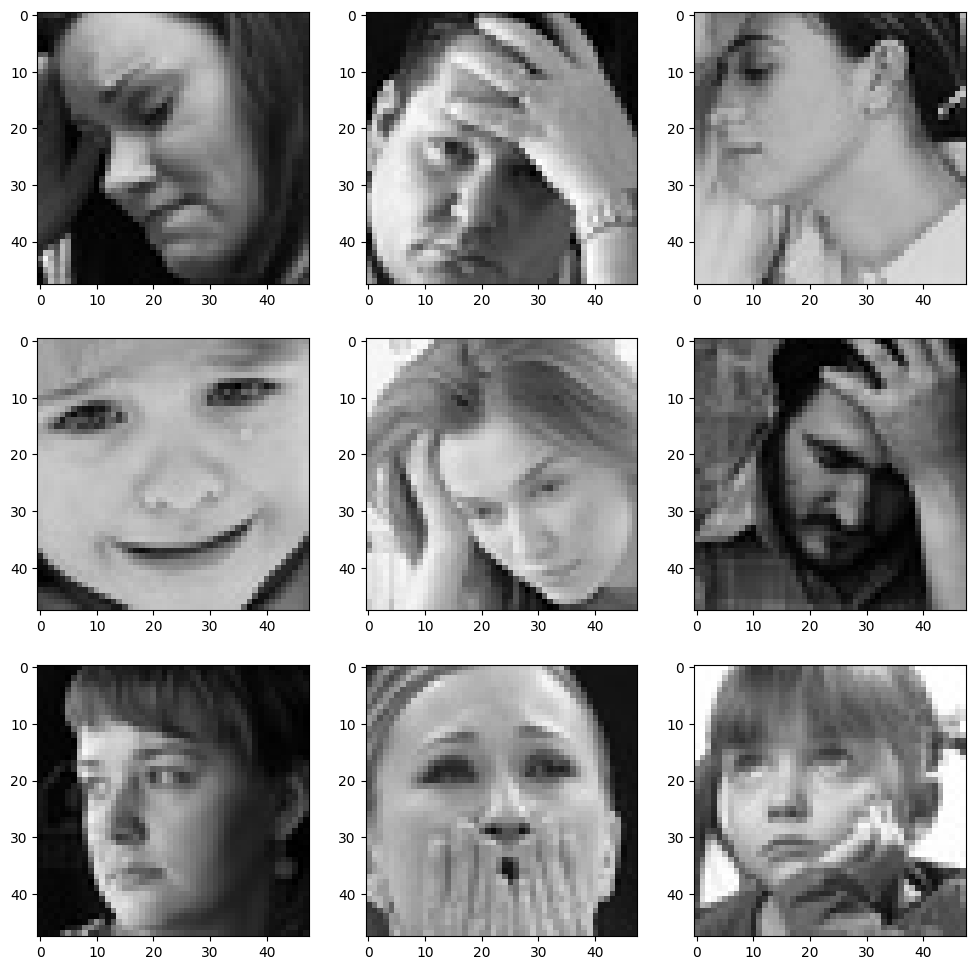

In [ ]:
# Visualize sample images from the dataset to understand the kind of data we are working with and ensure data integrity

expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [ ]:
batch_size  = 128 #Set batch size for training to balance between memory efficiency and training speed

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) # Data augmentation for the training set to increase the diversity of training data and improve model generalization

datagen_val = ImageDataGenerator(rescale=1./255) # Rescaling validation set images without augmentation for evaluation

train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale", # Use grayscale images to reduce computational complexity
                                              batch_size=batch_size,
                                              class_mode='categorical', # Categorical class mode for multi-class classification
                                              shuffle=True) # Shuffle data to ensure random distribution of images in each batch


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
no_of_classes = 7 # Define the number of output classes for the classification task

model_1 = Sequential() # Build the CNN model for image classification to recognize facial expressions

# Add convolutional layers to extract features from the images
# Each block of Conv2D, BatchNormalization, Activation, MaxPooling2D, and Dropout is used to build a deeper model while reducing overfitting

# 1st CNN layer
model_1.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1))) # Initial layer with input shape
model_1.add(BatchNormalization()) # Normalize to accelerate training
model_1.add(Activation('relu')) # ReLU activation for non-linearity
model_1.add(MaxPooling2D(pool_size=(2, 2))) # Downsample feature maps
model_1.add(Dropout(0.25)) # Dropout to prevent overfitting

# 2nd CNN layer
model_1.add(Conv2D(128, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# 3rd CNN layer
model_1.add(Conv2D(256, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# 4th CNN layer
model_1.add(Conv2D(512, (3, 3), padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

model_1.add(GlobalAveragePooling2D())

# Add fully connected layers to perform classification

# Fully connected layers
model_1.add(Dense(256))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.25))

model_1.add(Dense(no_of_classes, activation='softmax')) # Output layer with softmax activation for multi-class classification


In [ ]:
from keras.optimizers import Adam,SGD,RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Inspect the number of parameters and the structure of the neural network

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       7

In [ ]:
# Define callbacks for early stopping, checkpointing, and learning rate reduction to improve training efficiency and performance
checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # Save best model

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          ) # Stop training early if no improvement

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001) # Reduce learning rate if no improvement

callbacks_list = [early_stopping,checkpoint,reduce_learningrate]

epochs = 50

# Compile the model with Adam optimizer and categorical cross-entropy loss for multi-class classification

model_1.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
# Compute class weights to handle class imbalance and improve model performance on minority classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

# Convert class weights to a dictionary
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Train the model with the training set and validate with the validation set to evaluate performance
history = model_1.fit(
    train_set,
    steps_per_epoch=train_set.n // train_set.batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.n // test_set.batch_size,
    class_weight=class_weights,
    callbacks=callbacks_list
)

Epoch 1/50
225/225 [==============================] - ETA: 0s - loss: 2.0557 - accuracy: 0.1676
Epoch 1: val_accuracy improved from -inf to 0.19261, saving model to ./model.h5
225/225 [==============================] - 36s 123ms/step - loss: 2.0557 - accuracy: 0.1676 - val_loss: 1.9616 - val_accuracy: 0.1926 - lr: 0.0010


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
225/225 [==============================] - ETA: 0s - loss: 1.9773 - accuracy: 0.1811
Epoch 2: val_accuracy did not improve from 0.19261
225/225 [==============================] - 26s 116ms/step - loss: 1.9773 - accuracy: 0.1811 - val_loss: 1.9579 - val_accuracy: 0.1631 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - ETA: 0s - loss: 1.9186 - accuracy: 0.2097
Epoch 3: val_accuracy improved from 0.19261 to 0.26705, saving model to ./model.h5
225/225 [==============================] - 26s 117ms/step - loss: 1.9186 - accuracy: 0.2097 - val_loss: 1.8320 - val_accuracy: 0.2670 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - ETA: 0s - loss: 1.8654 - accuracy: 0.2256
Epoch 4: val_accuracy improved from 0.26705 to 0.30795, saving model to ./model.h5
225/225 [==============================] - 26s 116ms/step - loss: 1.8654 - accuracy: 0.2256 - val_loss: 1.7744 - val_accuracy: 0.3080 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - 

In [ ]:
# Save the trained model to a file named "emotions_2.h5" for future use and deployment
model_1.save("emotions_2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1. Utmaningar du haft under arbetet samt hur du hanterat dem.
- Utmaningen jag hade var när min modell bara visade känslorna "sad" för alla uttryck. Jag senare kunde lösa det med att använda Data Augmentation på träningsdatan och använda 'class weights'. Sedan kunde jag skapa en modell som till viss del kunde prediktera rätt. Träningen gick supersnabbt eftersom jag använde GPU med Google Colab.

2. Vilket betyg du anser att du skall ha och varför.
- Jag ser mig förhoppningsvis få en VG, eftersom jag har svarat på alla frågor, skapat en emotion-detekteringsmodell som upptäcker känslor på livekamera och sedan lagt till ytterligare förtränade modeller som känner av kön och ålder, vid sidan av känslor.

3. Tips du hade ”gett till dig själv” i början av kursen nu när du slutfört den.
- Tips jag skulle ha gett mig själv skulle vara att sluta slösa timmar på att träna din modell på Jupyter Notebook eller Kaggle, istället använda GPU på Colab.